In [ ]:
!pip install simpletransformers


In [ ]:
import simpletransformers
from simpletransformers.classification import ClassificationModel

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
model = ClassificationModel(  'distilbert', 'distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
train= pd.read_pickle('./trainnew.pkl')
test= pd.read_pickle('./testnew.pkl')

In [ ]:
from sklearn.metrics import roc_auc_score
model.train_model(train, metric= roc_auc_score)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(8135, 0.3833295882737909)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

result, model_outputs, wrong_predictions = model.eval_model(test, auc=roc_auc_score, f1=f1_score, acc= accuracy_score, prec= precision_score, rec=recall_score )

In [ ]:
result

{'acc': 0.8842461572609733,
 'auc': 0.8596214819054833,
 'eval_loss': 0.2858086724715374,
 'f1': 0.9132062910876259,
 'fn': 641,
 'fp': 1445,
 'mcc': 0.7438131129529686,
 'prec': 0.8836460262501007,
 'rec': 0.9448127421437796,
 'tn': 4961,
 'tp': 10974}

In [ ]:
model_outputs

array([[ 1.64355469, -1.73144531],
       [ 1.8828125 , -1.95019531],
       [ 1.8359375 , -1.9296875 ],
       ...,
       [ 1.41992188, -1.53710938],
       [ 1.55273438, -1.63378906],
       [ 1.32421875, -1.37792969]])

In [ ]:
len(test)

18021

In [ ]:
import pandas as pd
from textblob import TextBlob
import glob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
all_files = glob.glob("./dataset_cleaning/*.pkl")
all_files.sort()
datasets = []

for filename in all_files:
    print(filename)
    df = pd.read_pickle(filename)
    datasets.append(df)


./dataset_cleaning/dataset1Cleaned.pkl
./dataset_cleaning/dataset2Cleaned.pkl
./dataset_cleaning/dataset3Cleaned.pkl
./dataset_cleaning/dataset4Cleaned.pkl
./dataset_cleaning/dataset5Cleaned.pkl
./dataset_cleaning/dataset6Cleaned.pkl


In [ ]:

def text_processing(tweet):
    
    tweet= tweet.lower()
    
    #Removing hyperlinks from the tweet
    tweet_no_links=re.sub(r'http\S+', '', tweet)
    
    #Generating the list of words in the tweet (hashtags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet_no_links)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return " ".join(normalized_tweet)
    
    
    return normalization(no_punc_tweet)

In [ ]:
for i,ds in enumerate(datasets):
    print("Processing dataset {}".format(i+1))
    ds['text']=ds['text'].apply(text_processing)
    ds.rename(columns={'Informativeness': 'labels'}, inplace=True)

Processing dataset 1
Processing dataset 2
Processing dataset 3
Processing dataset 4
Processing dataset 5
Processing dataset 6


In [ ]:
datasets[0]

,labels,text
0,0,intern us tattoo wisconsin ohio nc pa florida ...
1,0,get fun every thursday csindependent funbrief ...
2,0,welcome newest studentathlete reagan biechler ...
3,0,denver post colorado governor sign bill create...
4,0,pretty sure go live manitou spring co someday ...
...,...,...
27814,0,leavingthedock west texas right moms
27815,0,many fertilizer plant texas
27816,0,sec west baseball stand lsu arkansas ole miss ...
27817,0,rt mountain_goats quick somebody ask ever go r...


In [ ]:
# for i,ds in enumerate(datasets):
#   datasets[i]=ds[['labels','text']]

In [ ]:
results=[]
feature_importance=[]

for i,ds_train in enumerate(datasets):

    print("Training on Dataset {}".format(i+1))
    row=[]

    
    model = ClassificationModel(  'distilbert', 'distilbert-base-uncased')
    model.train_model(ds_train, metric= roc_auc_score, args={'overwrite_output_dir': True})
    for j,ds_test in enumerate(datasets):
        
        print("testing on Dataset {}".format(j+1))

        result, model_outputs, wrong_predictions = model.eval_model(ds_test, auc=roc_auc_score, f1=f1_score, acc= accuracy_score, prec= precision_score, rec=recall_score )
        
        row.append(result)
    results.append(row)
    

Training on Dataset 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)




testing on Dataset 1


In [ ]:
res_auc=list(map( lambda x: list(map(lambda y: y['auc'],x)),results))

In [ ]:
df = pd.DataFrame(res_auc)
df.columns= map( lambda x: x+1,df.columns)
df.index= map( lambda x: x+1,df.index)

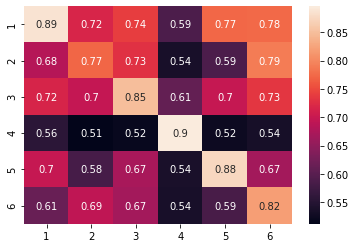

In [ ]:
sns.heatmap(df, annot=True)

In [ ]:
pd.to_pickle(results, './reslist.pkl')